In [3]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.stats import itemfreq
%matplotlib notebook


# Hands on Tutorial: Neural Networks

## General Goal
We want to find the best parameters $\theta$ to some function $$F_\theta(h_0) = h_L,$$ such that we can map our input data $$h_0 \in \mathbb{R}^{b\times n_{0,1}\times\dots \times n_{0,d} \times c_0}$$ to our target data $$h_L \in \mathbb{R}^{b \times n_{L,1}\times \dots \times n_{L,d} \times c_L}.$$ Since usually the whole data can't be fed into the network at once, and there are actually advantages of not doing so, we choose *minibatches* of $b$ samples to feed into the network at once. Depending on the data, we need different additional dimensions, ranging from just one-dimensional data ($h_0 \in \mathbb{R}^{b \times c_L}$) to multiple dimensions as for instance for images. The last dimension $c$ denotes the *feature map* or *channel*. Each of the $b$ samples we process at once has $c_l$ feature maps for each layer $l$, with dimensions $n_{l,1}\times \dots \times n_{l,d}$. 
## General Structure
A network is a combination of various small components, whose properties are well understood. Any differentiable function can theoretically be used as a component of a network. 

Classical networks can be roughly split into individual *layers*. Such layers usually follow a similar structure, which we will quickly go through in the next paragraph:

Consider a network of $L$ layers. The first component of each layer $l$ is a mapping function $\Psi_l(h_{l-1},\theta_l)$, which linearly combines the inputs, here the outputs of layer $l-1$:
$$z_l = \Psi_l(h_{l-1},\theta_{l}).$$
The weights $\theta_l$ of these linear combinations are parameters of the network, that we are going to *train*. Now, the so-called *activation function* $\Phi$ (also *nonlinearity* or *squashing function*) is applied:
$$a_l = \Phi_l(z_l,\theta_{l}).$$
Without this function, all our linear combinations could be reduced to one linear combination, which would greatly reduce the different functions we can approximate.

For classification networks, we can also use downsampling operations $\Gamma_l$, which could be pooling operations, convolutions with a stride larger than 1, or if not present, just the identity transform:
$$h_l = \Gamma_l(a_l,\theta_l).$$

In summary, one full layer can then be described as the application of the combined function $\Lambda_l$ to the previous layer's output $h_{l-1}$, using weights $\theta_l$:
$$h_l = \Lambda_l(h_{l-1},\theta_l) = \Gamma_l(\Phi_l(\Psi_l(h_{l-1},\theta_l),\theta_l),\theta_l).$$
The first layer just takes the input data instead of the previous layer's output.

After the last layer, we finally add a *cost function* (also *loss* or *objective function*), which lets us define what we want the network to learn. Given we are applying supervised learning and are provided with labels  $y$, we can define a loss $\mathcal{L}(h_L)$. We now want to find the weights $\theta$ that minimize this loss:
$$\DeclareMathOperator*{\argmin}{arg\,min}
\argmin_\theta \mathcal{L}(h_L, y).$$

Since the concept of layers is differently defined and is only partly useful when defining the graph structure of a network, we will continue our explanations with respect to the individual components making up layers. The stacking of those to one classical layer is then a straight-forward task. In the following, we will use **component**, **layer**, and **node** interchangeably for one atomic element of our network graph!

## Simple Example
### Data
Now that we have the basics, we can experiment with the famous, very simple iris dataset:
it contains the following information for 150 samples of measurements on flowers from the genus *Iris*:
1. sepal length in cm 
2. sepal width in cm 
3. petal length in cm 
4. petal width in cm 
5. class: 
  - *Iris Setosa* 
  - *Iris Versicolor* 
  - *Iris Virginica*

In terms of our definitions from above, we have a supervised learning task, where for each training sample of our one-dimensional, four-channel input data, we know the label $y$. The four channels are given by the four measurements (sepal length, sepal width, …), the label is given by the class (the specific *Iris* species).

The following code loads the data into an array and shows an example entry:



In [4]:
#load data from csv file
with open('iris.csv', 'r') as csvfile:
    data = np.asarray([row for row in csv.reader(csvfile, delimiter=',') if row])
#shuffle data
np.random.shuffle(data)
#create numeric values and lookup tables to transform from text to numbers and back
lt = {j[0]:i for i,j in enumerate(itemfreq([d[-1] for d in data]))}
ltb = {i:j for j,i in lt.items()}
#create labels and data array, and split into training and testing set
labels = [lt[d] for d in data[:,-1]]
data = np.float64(data[:,:-1])
train_data,test_data = (data[:100],data[100:])
train_labels,test_labels = (labels[:100],labels[100:])
#show 10th training sample as example
print("10th training sample:",train_data[10],ltb[train_labels[10]])

10th training sample: [5.8 2.6 4.  1.2] Iris-versicolor


We will use the following class to sample from our data:

In [5]:
class IrisSampler:
    '''Data sampler'''
    def __init__(self,data,labels,normalize=True):
        if normalize:
            data = (data-np.mean(data,0,keepdims=True))/np.std(data,0,keepdims=True)
        self._data = data
        self._labels = labels
    def random_sample(self,n=1):
        locs = [np.random.randint(len(self._labels)) for _ in range(n)]
        d = np.asarray([self._data[l] for l in locs])
        l = np.asarray([self._labels[l] for l in locs])
        return d,l
    def sample_all(self):
        locs = np.arange(len(self._labels))
        for l in locs:
            yield np.asarray([self._data[l]]),np.asarray([self._labels[l]])


For both training and test set, we will create one IrisSampler. **random_sample** returns one random row of the data and **sample_all** can be used to iterate once through the data.

In [6]:
sa_te = IrisSampler(test_data,test_labels,normalize=True)
sa_tr = IrisSampler(train_data,train_labels,normalize=True)

#random training example:
print(sa_tr.random_sample())
#first 2 test examples:
gen = sa_te.sample_all()
print([gen.__next__() for _ in range(2)])

(array([[-0.92740466, -1.29181257, -0.38508068, -0.09950854]]), array([1]))
[(array([[1.05446008, 0.28427353, 0.32202288, 0.21596552]]), array([1])), (array([[-1.44482453,  0.54748976, -1.52161956, -1.42427897]]), array([0]))]


## Network

For this data, we will design a very simple network. It will consist of one fully connected hidden layer and a fully connected output layer. Since this is a classification task, we will use a softmax function in the end and a cross entropy loss function. Due to the scalar nature of the features in this dataset, our input data lies in $\mathbb{R}^{b\times c_0}$.

We will use the *Comp* class to describe individual components of the network. Its *forward* method will compute the data flow through from its inputs to its output. And we will use the *Network* class to glue them together. 

In [7]:
class Comp:
    '''Base class for each component of the network'''
    def forward(self,i):
        pass
    
class Network:
    '''Lets you compose, evaluate and derive a network'''
    def __init__(self):
        self._comps = []
        self._loss = []
        self.ls,self.ls_te,self.ls_tr = [],[],[]
    def add_component(self,comp):
        self._comps.append(comp)
    def set_loss(self,loss):
        self._loss = loss
    def forward(self,h,y):
        for co in self._comps:
            h = co.forward(h)
        return self._loss.loss(h,y)

### Explanation of components used for this example:
For all components in our layer, we now need to define a *Comp* class!
#### Fully connected layer:
A fully connected layer $\Psi_{FC}$ connects at least in one dimension all input nodes to all output nodes. This can easily be described as a Matrix multiplication on all dimensions except the first one of $h$ and $x$ ($h$ and $x$ are only two-dimensional, since we have scalar features):
$$h = \Psi_{FC}(x,W) = xW.$$

It might seem odd that we choose to calculate $xW$ instead of $Wx$, but this has some practical reasons. Usually, fully connected layers are calculated either over channels only (last dimension) or over spatial dimensions and channel combined (all except first dimension). If we would want to calculate $Wx$, we'd need to transpose our data. With $xW$, we only need to reshape the data.

The number of columns of matrix $W$ has to match the number of channels of input $x$; the number of rows has to match the number of channels in the output $h$.


In [8]:
class FC(Comp):
    '''Fully connected layer'''
    def __init__(self,inpsize,outsize):
        self._dims = len(inpsize[1:])
        shape = (np.prod(inpsize[1:]),np.prod(outsize[1:]))
        self._W = np.random.normal(0,1.3*2/np.sqrt(np.sum(shape)),np.prod(shape)).reshape(shape)
    def forward(self,i):
        if self._dims != 1:
            raise Exception('might implement some reshaping here')
        self._i = i
        return self._i@self._W

If we had multi-dimensional data instead of scalar values as features, for a true fully connected layer, we'd need to reshape the data.
#### Hyperbolic Tangent activation function
This activation function maps all values from $(-\infty, +\infty)$ to $(-1, +1)$:
$$\Phi_{TanH}(z_L) = \tanh z_L = \frac{\sinh z_L}{\cosh z_L} = \frac {e^{z_L} - e^{-z_L}} {e^{z_L} + e^{-z_L}} = \frac{e^{2z_L} - 1} {e^{2z_L} + 1} $$


In [9]:
class TanH(Comp):
    '''TanH activation function'''
    def __init__(self):
        pass
    def forward(self,i):
        self._i = i
        return np.tanh(self._i)
    


#### Softmax activation function
The softmax function is used whenever we need a (pseudo-)probability distribution. It maps all $C$ channels into probabilities, with a sum of 1. It can be seen as an approximation of an argmax function, since the distribution encodes an approximation of a one-hot encoding for the chosen class:
$$\Phi_{SM}(z_L)_j = \frac{e^{z_{L,j}}}{\sum_{k=1}^C e^{z_{L,k}}}$$


In [10]:

class Softmax(Comp):
    '''Softmax activation function'''
    def forward(self,i):
        return np.exp(i)/np.sum(np.exp(i))
    


#### Cross entropy loss function
With cross entropy $H$ defined as the sum of all entropies of the true probability $p$ and the estimated probability $q$ for all classes, that is
$$H(p,q) = -\sum_i p_i\log q_i,$$
the cross entropy loss is defined as 
$$ \mathcal L(h_L,y) = -\frac1N \sum_{n=1}^N H(h_{L,n},p_{y_n}),$$
where $N$ is the number of samples in the output layer.
In any case, we can use a softmax activation function to create a discrete probability distribution over the $c$ channels, and apply the above formula.

In the special case of 2 classes, we could use a sigmoid to produce an output of 1 channel. The cross entropy then takes the form:
$$\mathcal L(h_L,y)= -\frac1N \sum_{n=1}^N \bigg[ p_{y_n}  \log h_{L,n} + (1 - p_{y_n})  \log (1 - h_{L,n})\bigg]\,.$$

If we use binary class probabilities, for both cases, $\mathcal L(h_L,y)$ will be simplified to 
$$L(h_L,y) = -\frac1N \sum_{n=1}^N p_{y_n,\textbf{c}} \log h_{L,n,\textbf{c}},$$
where $\textbf{c}$ denotes the correct class for each sample n.


In [11]:
class SoftmaxLoss(Softmax):
    '''Softmax combined with cross entropy (numerical benefits, easier calculation)'''
    def loss(self,i,y):
        self._i = i
        self._p = super(SoftmaxLoss,self).forward(self._i)
        return self._p,-self._i[:,y]+np.log(np.sum(np.exp(self._i)))
    







### Forward computation
Now let's implement this in some lines of code:

In [12]:
def create_example_network():
    n = Network()
    n.add_component(FC([1,4],[1,30]))
    n.add_component(TanH())
    n.add_component(FC([1,30],[1,3]))
    n.set_loss(SoftmaxLoss())
    return n



In [13]:
np.random.seed(123)
n = create_example_network()
rs,ls = [],[]
for d,c in sa_te.sample_all():
    r,l = n.forward(d,c)
    rs.append(r),ls.append(l)
    #print('d:{}, c:{}, predicted: {}->{}, loss: {}'.format(d,c,r,np.argmax(r,-1),l))
print('average loss: {}'.format(np.mean(ls)))


average loss: 2.358797192803537


### How are we going to optimize these weights?
Obviously, this is not yet it. We just used the initialized weights to compute predictions, which have nothing to do with our data yet. We can now differentiate our network with respect to each parameter in the network and with every training sample use the respective gradient to adjust the weights. With large $L$, we will have a very complex stacked model, which we want to optimize. Here, the backpropagation trick comes into play!


# Understanding backpropagation

In terms of layers, backpropagation can be explained in a simplified version. Let's assume we have a network of $L$ layers $\Lambda_l$ with $l \in 1...L$:
<!-- Why is this called $F_l$ now, not $\Lambda_l$, like in the very beginning? FIXED-->
$$h_l = \Lambda_l(h_{l-1},\theta_l),$$
a loss function $\mathcal{L}(h_L,y)$ that computes some error metric from the last output and the true labels $y$. 

Now, for every parameters $\theta_{l,i}$ of each layer $l$, we want to find the partial derivative of the loss function with respect to that parameter:
$$
\newcommand{pdv}[2]{\frac{\partial #1}{\partial #2}}
\Delta \theta_{l,i} = \pdv{\mathcal{L}(h_L,y)}{\theta_{l,i}}$$
We then move along that gradient in the variable space and adjust the value of $\theta_{l,i}$ at iteration $k$ along that direction:
$$\theta^{(k)}_{l,i} = - \theta^{(k-1)}_{l,i}+\Delta \theta_{l,i}^{(k)}$$
<!-- This would be gradient ascent rather than descent, i.e. this would maximize the loss! FIXED, thanks -->

## How can we do this efficiently?

Using the chain rule, the above term can be factored into the gradients of the loss with respect to the current layer and the current layer with respect to the current layers weights:
$$\pdv{\mathcal{L}(h_L,y)}{\theta_{l,i}} = \pdv{h_l}{\theta_{l,i}} \pdv{\mathcal{L}(h_L,y)}{h_l}$$

The first part, $\pdv{h_l}{\theta_{l,i}}$, should in most cases be relatively easy to analytically derive. The second part is again subject to the chain rule:

$$\pdv{\mathcal{L}(h_L,y)}{h_l}  =\left (\prod_l^{L-1} \pdv{h_{l+1}}{h_l} \right) \pdv{\mathcal{L}(h_L,y)}{h_l}, $$
Where $\pdv{h_{l+1}}{h_l}$ is just the gradient of Layer $F_{l+1}$ with respect to its input $h_l$
<!-- The running variable of the product should be $i$ rather than $l$, right? -->

The only thing that is missing now is the loss term $\pdv{\mathcal{L}(h_L,y)}{h_L}$, which is just the gradient of the loss term with respect to its inputs $h_L$. 




## Now, let's try this on our example:
First, we need to update our Components to be able to handle backpropagation.
### Updated Component Class 

In [14]:
class Comp:
    '''Base class for each component of the network'''
    def update_weights(self,lr):
        pass
    def forward(self,i):
        '''computes forward pass from input i. '''
        pass
    def backward(self,do):
        '''computes backward pass from gradient of output do'''
        pass

The *backward* method guides the gradient(s) of the next component(s) backwards through the network. Using the gradient of our output (*do*), we can calculate the gradient of the loss with respect to our weights and with respect to our input. The method saves the gradients of the weights and returns the gradients of the input for further use. 

The method *update_weights* then takes a learning rate, and adjusts the weights by that fraction using the previously calculated gradient.

### Updated Network Class 
For the network, we introduce three new methods, *backward*,*update_weights* and *train*. The *backward* and *update_weights* methods call all the respective functions in the components of the network. The *train* method takes the samplers *sa_tr* and *sa_te* for training and testing as arguments. For the provided number of iterations *its*, *forward*,*backward* and *update_weights* is called to calculate predictions and their loss, the gradients and to update the weights accordingly. The *test_each* parameter can be used to collect information about the loss of the whole training and the whole testing dataset, which are saved in the networks *ls_te* and *ls_tr* arrays.

In [15]:
class Network:
    def __init__(self):
        self._comps = []
        self._loss = []
        self.ls,self.ls_te,self.ls_tr = [],[],[]
    def add_component(self,comp):
        self._comps.append(comp)
    def set_loss(self,loss):
        self._loss = loss
    def forward(self,h,y):
        for co in self._comps:
            h = co.forward(h)
        return self._loss.loss(h,y)
    def backward(self,y):
        do = self._loss.dloss(y)
        for co in self._comps[::-1]:  # Step of -1 means going backward through the list of components
            do = co.backward(do)
    def update_weights(self,lr):
        for co in self._comps:
            co.update_weights(lr)
    def train(self,sa_tr,sa_te,its=1000,lr=0.01,test_each=100):
        for i in range(its):
            d,c = sa_tr.random_sample()
            r,l = self.forward(d,c)
            self.ls.append(np.mean(l))
            self.backward(c)
            self.update_weights(lr)
            #each #test_each iterations, we test the whole training and test set
            if (i+1)%test_each == 0:
                #print('d:{}, c:{}, predicted: {}->{}, loss: {}'.format(d,c,r,np.argmax(r,-1),l))
                _,tmp,_ = self._test(sa_te)
                self.ls_te.append(np.mean(tmp))
                _,tmp,_ = self._test(sa_tr)
                self.ls_tr.append(np.mean(tmp))
                #print('iteration {}: avg tr loss: {}, avg te loss: {}'.format(i,ls_tr[-1],ls_te[-1]))
    def _test(self,s):
        rs,ls,cs = [],[],[]
        for d,c in s.sample_all():
            r,l = self.forward(d,c)
            rs.append(r),ls.append(l),cs.append(c)
        return rs,ls,cs
    def test(self,sa_te):
        rs,ls,cs = self._test(sa_te)
        acc = np.sum([c==np.argmax(r) for c,r in zip(cs,rs)])/len(cs)
        print('average loss: {}, correctly classified: {}, '.format(np.mean(ls), acc))
        return rs

### Updated Components
#### Fully Connected Component
For the fully connected layer, we need to implement the gradient with respect to the weights $\pdv{\mathcal{L}(h_L,y)}{\theta_{l,i}}$ and the gradient with respect its input $\pdv{\mathcal{L}(h_L,y)}{h_{l-1}}$:
$$\pdv{\mathcal{L}(h_L,y)}{\theta_{l,i}} = \pdv{h_l}{W} \pdv{\mathcal{L}(h_L,y)}{h_l}= \pdv{h_{l-1}W}{W} \pdv{\mathcal{L}(h_L,y)}{h_l},$$
$$\pdv{\mathcal{L}(h_L,y)}{h_{l-1}}  =  \pdv{\mathcal{L}(h_L,y)}{h_l}\pdv{h_l}{h_{l-1}}= \pdv{\mathcal{L}(h_L,y)}{h_l}\pdv{h_{l-1}W}{h_{l-1}},$$
where we already know $\pdv{\mathcal{L}(h_L,y)}{h_l}$, and $\theta_{l,i}$ in this case is $W$.

With this we have: 
$$\pdv{h_{l-1}W}{W} = h_{l-1}^T,$$
$$\pdv{h_{l-1}W}{h_{l-1}} = W^T$$

In [16]:
class FC(Comp):
    '''Fully connected layer'''
    def __init__(self,inpsize,outsize):
        self._dims = len(inpsize[1:])
        shape = (np.prod(inpsize[1:]),np.prod(outsize[1:]))
        self._W = np.random.normal(0,1.3*2/np.sqrt(np.sum(shape)),np.prod(shape)).reshape(shape)
    def forward(self,i):
        if self._dims != 1:
            raise Exception('might implement some reshaping here')
        self._i = i
        return self._i@self._W
    def backward(self,do):
        if self._dims != 1:
            raise Exception('might implement some reshaping here')
        self._dW = self._i.T@do
        return do@self._W.T
    def update_weights(self,lr):
        self._W -= lr*self._dW

#### Hyperbolic Tangent
Since there are no parameters, the derivative is easy. With 
$$h_l = \tanh h_{l-1},$$
we get
$$\pdv{\mathcal{L}(h_L,y)}{h_{l-1}}= \pdv{\mathcal{L}(h_L,y)}{h_l}\pdv{h_l}{h_{l-1}} = \pdv{\mathcal{L}(h_L,y)}{h_l} (1-(\tanh h_{l-1})^2)$$

In [17]:

class TanH(Comp):
    '''Hyperbolic tangent'''
    def __init__(self):
        pass
    def forward(self,i):
        self._i = i
        return np.tanh(self._i)
    def backward(self,do):
        return do*(1-np.tanh(self._i)**2)
    

#### Softmax
We omit the implementation of the derivative of the Softmax, since we will always compute it jointly with the cross entropy loss!

In [18]:

class Softmax(Comp):
    '''Softmax activation Function'''
    def forward(self,i):
        zi = np.exp(i-np.max(i)) 
        # the -np.max(i) normalizes values, better conditioning the softmax. 
        # There will always be a 1 in the denominator and the values are not likely to explode, 
        # since the maximum is now 0. Also, it doesn't affect the gradient.
        return zi/np.sum(zi)
    


#### Cross entropy loss and softmax 

If we combine cross entropy and the softmax function, the loss of the cross entropy becomes:
$$\mathcal{L}(\Phi_{SM}(h_L), y) =  - \sum_c^C p_{y=c} \log \Phi_{SM}(h_L)_{y}$$
$$ = - \sum_c^C p_{y=c} \log  \frac{e^{h_{L,c}}}{\sum_{k=1}^C e^{h_{L,k}}}$$
and with binary probabilities of the label y we have
$$ = - \log \frac{e^{h_{L,y}}}{\sum_{k=1}^C e^{h_{L,k}}}$$
$$= - h_{L,y} + \log \sum_{k=1}^C e^{h_{L,k}}$$
Now, if we differentiate this with respect to the input of the softmax function, we can see that both terms together simplify to the derivative of the softmax simplifies to:
$$\pdv{\mathcal{L}(\Phi_{SM}(h_L),y)}{h_{L,c}} = \pdv{- h_{L,y}}{h_{L,c}} + \pdv{\log \sum_{k=1}^C e^{h_{L,k}}}{h_{L,c}} = -p_{y=c} + \Phi_{SM}(h_L)_c = \begin{cases}
-1 + \Phi_{SM}(h_L)_c & \text{if } y==c\\
\Phi_{SM}(h_L)_c &\text{else}
\end{cases}$$


In [19]:

class SoftmaxLoss(Softmax):
    '''Combination of Cross entropy and Softmax activation function (less code, better numerical stability)'''
    def loss(self,i,y):
        self._i = i
        self._p = super(SoftmaxLoss,self).forward(self._i)
        return self._p,-self._i[:,y]+np.log(np.sum(np.exp(self._i)))
    def dloss(self,y):
        return np.asarray([[-1.0*(yy==cc) +pp for cc,pp in enumerate(p)] for p,yy in zip(self._p,y)])
    


### Training of the Network

Let's now train our network and evaluate it on the test set. Feel free to experiment with the network parameters: The number of iterations can be set with *iterations*, which will be run for *run* times if the learning rate is fixed. You can specify, how often you want to evaluate your network to gather statistics on its performance by setting *test_each*. If you want to use a learning rate annealing, set *fixed_lr* to false, and feel free to also implement your own *decay_func*. The *decay_func* here divides the learning rate after each run by decay_rate. If you feel adventurous, you can also modify our network structure by writing an additional example_network function by copying *create_example_network* and changing its attributes. You can then add your new function below in the code. 

After the network has been trained, we evaluate it a last time and plot the statistics gathered during training and testing. The first plot shows how the training and testing error compares during the training of the network, and the second shows the training error for each iteration we trained our network for.

Before training:
average loss: 1.4480752868255444, correctly classified: 0.22, 
After training:
average loss: 0.2682419159954573, correctly classified: 0.88, 


<IPython.core.display.Javascript object>


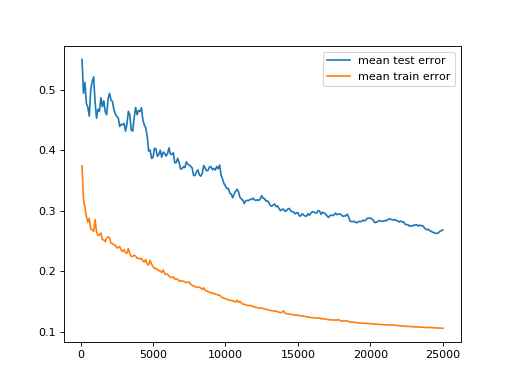

<IPython.core.display.Javascript object>


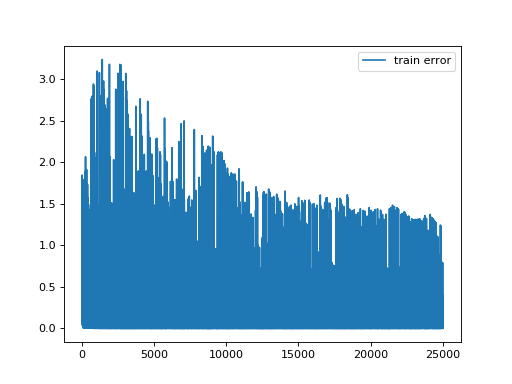

In [20]:


#seed for reproducability:
np.random.seed(123456)
n = create_example_network()

#first check crossentropy for initialized but untrained network:
print("Before training:")
n.test(sa_te)

#now train the network. either with a fixed learning rate, or a decaying one:
#define number training iterations and learning rate:

rs,ls = [],[]
test_each = 100
iterations = 1000
runs = 25
lr = 0.01
fixed_lr = False
decay_rate = 1.1
decay_func = lambda lr,decay_rate,it: lr/decay_rate**it

if fixed_lr:
    #fixed:
    n.train(sa_tr,sa_te,its = iterations*runs,lr =lr,test_each = test_each)
else:
    #decaying:
    for i in range(runs):
        n.train(sa_tr,sa_te,its = iterations,lr =decay_func(lr,decay_rate,i),test_each = test_each)

#let's see if we did better:
print("After training:")
n.test(sa_te)

#and plot first the average training and testing error at each test_each during the training:
plt.figure()
x = np.arange(test_each,iterations*runs+1,test_each)
plt.plot(x,n.ls_te,label='mean test error')
plt.plot(x,n.ls_tr,label='mean train error')
plt.legend()
plt.show()

#and the training error itself for each iteration:
plt.figure()
plt.plot(n.ls,label='train error')
plt.legend()
plt.show()



<!--**Work in progress**

## Network Components in more Detail
Recently, the distinction between individual layer has become more and more difficult, it is hence a lot easier sometimes to just think of components in a computational graph, which can be used for the forward calculation, as well as the back propagation of error gradients. We will define a number of groups of such components with similar usages: 
## Mapping functions
Mapping functions are used to create linear combinations from the input at 


### Examples for mapping functions between layers

A convolutional layer $\Psi_{conv}$ does additionally consider the immediate neighborhood of each data point. Lets -->